<a href="https://colab.research.google.com/github/Tbharvesh/DeepLearning/blob/main/notebook0cf4527f57.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-classification-mri:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F672377%2F1183165%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T154108Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6658f14f852c514fc46dfaa86ebf6d6c2363bdc11495e152ca1a4e2028d2669db1f2e74ffdd4935504752b6b2561beed9844d9b27dea8e9abfee32ce3f364ca4e8b0f3a4f185231335ffd5849a99e57aa9b19ff3f9189154a35764e88d7f11393a86fad6d6a8a550cb32643e44898472cf310c9366e04dea0b25ae5d7e7ead46b44cfd5d21824d758d4789ae6b9cf3cce4b6d3785720c03b8a9546b9d69c421d584610e9b65238619adb6654b33d2d5555e43b92dc8e53f06b07af4704baf1c6190bedfd2b92d77af1b1ae99ef7105c0f55b518797472863d573f7f30377f04d92e58665eab39291977a78859b1506de66d9f7bac9f17e5cf9c8584c71f4c27b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Populating the interactive namespace from numpy and matplotlib


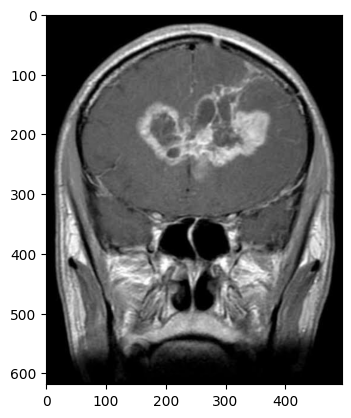

In [10]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg')
imgplot = plt.imshow(img)
plt.show()

## Import Libraries

In [11]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
print(tensorflow.__version__)

2.15.0


## Design the Model

### Initialize Parameters

In [40]:
img_width,img_height=150,150
train_dir=r"/kaggle/input/brain-tumor-classification-mri/Training"
val_dir = r"/kaggle/input/brain-tumor-classification-mri/Testing"
nb_train_sample=10
nb_val_sample=10
epochs=20
batch_size=20

In [14]:
import tensorflow.keras.backend as t
if t.image_data_format()=='channel_first':
  input_shape=(3,img_width,img_height)
else:
  input_shape=(img_width,img_height,3)

In [52]:
train_data=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip =True)

test_data=ImageDataGenerator(rescale=1./255)

train_generator=train_data.flow_from_directory(train_dir,target_size =(img_width,img_height), batch_size=batch_size,class_mode='sparse',classes=['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'])

validation_generator =test_data.flow_from_directory(val_dir,target_size =(img_width,img_height), batch_size=batch_size,class_mode='sparse')


Found 2379 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


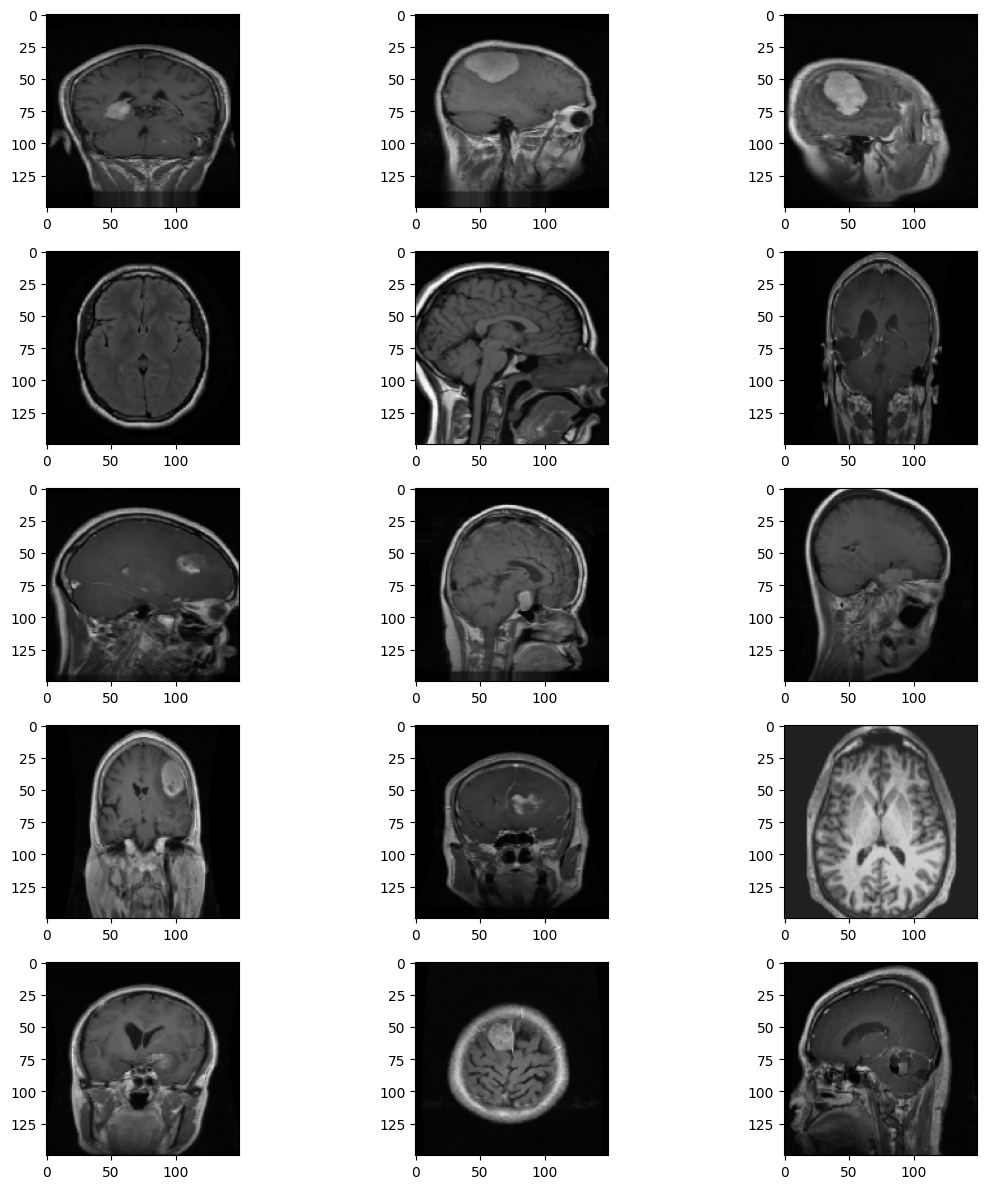

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [56]:
model =Sequential()
# model.add(Conv2D(64,(3,3),input_shape=input_shape,activation='softmax'))
# model0 =Sequential()
model.add(Dense(14,input_shape=input_shape,name='dense_layer',activation='softmax'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dense(4)) #output layer ~ 4 claasses
# model.add(Activation('softmax')) #softmax activation function ~Multiclass classifictaion
# model.summary()

In [61]:
model = Sequential()

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))

model.add(Conv2D(filters=96,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))


model.add(Flatten())
model.add(Dense(120,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(120,activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 147, 147, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 145, 145, 96)      110688    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 144, 144, 96)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 142, 142, 64)      55360     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 141, 141, 64)     

In [ ]:
# training= model.fit(train_generator, batch_size=32,
#                     epochs=5,
#                     validation_data=validation_generator)

## Compile the CNN Model

In [57]:
# from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# training = model.fit_generator(train_generator,
#                    steps_per_epoch=nb_train_sample,
#                    epochs=epochs,
#                    validation_data=validation_generator,
#                        validation_steps=nb_val_sample)

In [ ]:
from PIL import Image
import io
byteImgIO = io.BytesIO()
byteImg = Image.open("")
byteImg.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()


# Non test code
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)